In [88]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [89]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


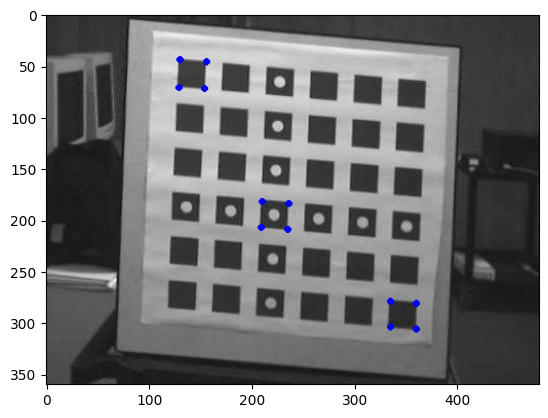

In [90]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [91]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# 四个点是从左上开始顺时针绕一圈的
lefttop_x=np.array([0,160,400])
lefttop_y=np.array([0,240,400])
delta_x=np.array([0,50,50,0])
delta_y=np.array([0,0,50,50])

front_3Dcoord = np.zeros((12, 3))

front_3Dcoord[:,0]=(lefttop_x[:,None]+delta_x).flatten()
front_3Dcoord[:,1]=(lefttop_y[:,None]+delta_y).flatten()
back_3Dcoord=front_3Dcoord.copy()
back_3Dcoord[:,2]=150
# ------------TODO----------------


all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [92]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
P = np.zeros((48, 12))
m = np.zeros((12, 1))

homo_3D= np.concatenate((all_3Dcoord, np.ones((24,1))), axis=1) # 24*4
homo_2D= np.concatenate((all_2Dcoord, np.ones((24,1))), axis=1) # 24*3

P[::2, 0:4] = homo_3D
P[1::2, 4:8] = homo_3D
P[::2, 8:] = -homo_3D*(homo_2D[:,0,None])
P[1::2, 8:] = -homo_3D*(homo_2D[:,1,None])

U, S, Vt = np.linalg.svd(P)
m = Vt[-1].reshape(12, 1)  # 选择与最小奇异值对应的奇异向量

print('m:\n',m.reshape((3,4)))
# ------------TODO----------------

m:
 [[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426065e-08  8.23266294e-08 -1.33752673e-08  7.29214554e-03]]


In [93]:
# ------------TODO----------------
# Solve K, and [R T] from m
K = np.zeros((3, 3))
R = np.zeros((3, 3))
T = np.zeros((3, 1))

m = m.reshape(3,4)
m1 = m[0, 0:3]
m2 = m[1, 0:3]
m3 = m[2, 0:3]
b= m[:, 3]

rho = 1/np.linalg.norm(m3)  # 1/||m3||
c_x= rho**2 * np.dot(m1, m3)  # rho^2 * m1^T * m3
c_y= rho**2 * np.dot(m2, m3)  # rho^2 * m2^T * m3
cos_theta = np.dot(np.cross(m3, m1),np.cross(m2, m3)) / (np.linalg.norm(np.cross(m3, m1)) * np.linalg.norm(np.cross(m2, m3)))
sin_theta= np.sqrt(1-cos_theta**2)
alpha=rho**2*np.linalg.norm(np.cross(m1, m3))*sin_theta  # rho^2 * ||m1 x m3|| * sqrt(1-cos^2)
beta=rho**2*np.linalg.norm(np.cross(m2, m3))*sin_theta  # rho^2 * ||m2 x m3|| * sqrt(1-cos^2)
K = np.array([[alpha, -alpha*cos_theta/sin_theta, c_x],
             [0, beta/sin_theta, c_y],
             [0, 0, 1]])

R[0, :] = np.cross(m2, m3)/np.linalg.norm(np.cross(m2, m3))  # m2 x m3 / ||m2 x m3||
R[2, :] = rho*m3
R[1, :] = np.cross(R[2, :], R[0, :])  # m3 x m1

T = rho*np.linalg.inv(K)@b  # rho * K^-1 * m3
# ------------TODO----------------

In [94]:
# save results
print('m',m, '\nK',K, '\nR',R, '\nT',T)
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.

m [[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426065e-08  8.23266294e-08 -1.33752673e-08  7.29214554e-03]] 
K [[ 8.79502211e+03  2.54151912e+04 -2.45693869e+04]
 [ 0.00000000e+00  2.60097274e+04  2.61653182e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
R [[ 0.03052016  0.18542639  0.98218408]
 [ 0.76653829  0.62628989 -0.14205641]
 [-0.64147297  0.75721729 -0.12302196]] 
T [383001.83680588 -67357.81783291  67071.11331876]
